In [1]:
import sys
sys.path.append("../")

import numpy as np
import itertools
from dataclasses import dataclass, field
from typing import Optional
from rl.chapter9.order_book import *
from rl.markov_process import *
from rl.distribution import Choose, Distribution, Gaussian, SampledDistribution, Poisson
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 7)

### Create the `OrderBookSimulator` class:

In [2]:
@dataclass(frozen=True)
class OrderBookSimulator(MarkovProcess):
    transitions : Dict[str, Distribution]
    num_orders : int
    order_types : List[str]
    order_weights : List[float]

    def print_state(self, state : OrderBook) -> None:
        print("Order Book:")
        print("--------------")
        print("Descending bids:")
        for s in state.state.descending_bids:
            print(s)
        
        print("\nAscending asks:")
        for s in state.state.ascending_asks:
            print(s)

    def transition(self, state: OrderBook) -> Optional[Distribution[OrderBook]]:
        '''
        here, we create 10 different orders and the resulting OrderBook
        and then pick one at random
        '''
        if not state.state.ascending_asks or not state.state.descending_bids:
            return None

        next_states = []
        for _ in range(self.num_orders):
            # randomly choose the type of order
            order_type = np.random.choice(self.order_types, p=self.order_weights)
            
            if order_type == 'market-buy':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.state.buy_market_order(shares=new_shares)

            elif order_type == 'market-sell':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.state.sell_market_order(shares=new_shares)
            
            elif order_type == 'limit-buy':
                # ensure that the random price is lower than the current ask price
                new_price = self.transitions['limit-price'].sample()

                while new_price > state.state.ask_price():
                    new_price = self.transitions['limit-price'].sample()

                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.state.buy_limit_order(price=round(new_price, 2), shares=new_shares)
            
            elif order_type == 'limit-sell':
                # ensure that the random price is greater than the current bid price
                new_price = self.transitions['limit-price'].sample()

                while new_price < state.state.bid_price():
                    new_price = self.transitions['limit-price'].sample()

                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.state.sell_limit_order(price=round(new_price, 2), shares=new_shares)

            next_states.append(NonTerminal(next_state))
        
        return Choose(next_states)

### Create an `OrderBook` instance and see how the book looks like:

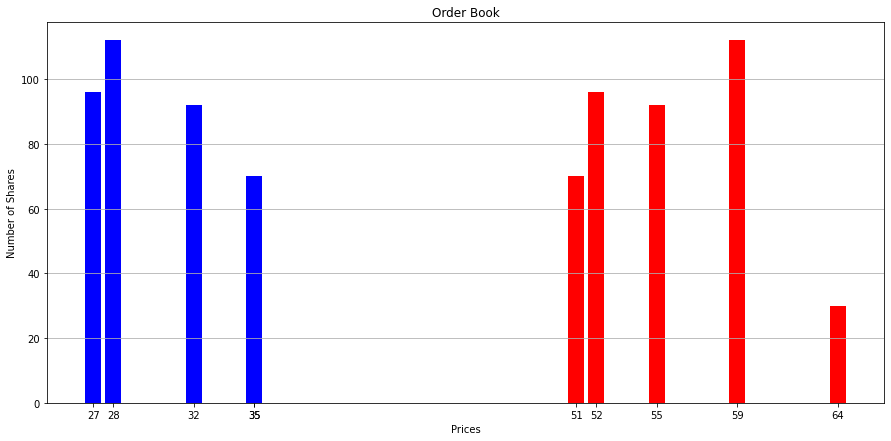

In [3]:
num_asks = 5
num_bids = 5

np.random.seed(42)

prices : Sequence[float] = np.abs(np.random.randint(low=45.0, high=65.0, size=num_asks))
shares : Sequence[int] = np.random.randint(10, 120, size=num_asks)
asks_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars, reverse=True)

prices : Sequence[float] = np.abs(np.random.randint(low=25.0, high=45.0, size=num_asks))
bids_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars)


book : OrderBook = NonTerminal(OrderBook(descending_bids=bids_list, ascending_asks=asks_list))
book.state.display_order_book()

### Set up the distributions of the prices and the shares for the simulator and then create an instance of the `OrderBookSimulator`:

In [4]:
np.random.seed(42)

transitions = {'market-shares' : SampledDistribution(sampler=lambda : np.random.randint(10, 41)), 
               'limit-price' : SampledDistribution(sampler=lambda : np.random.uniform(40, 61)), 
               'limit-shares' : SampledDistribution(sampler=lambda : np.random.randint(10, 41))}

simulator = OrderBookSimulator(transitions=transitions, 
                               num_orders=5, 
                               order_types=['market-buy', 'market-sell', 'limit-buy', 'limit-sell'], 
                               order_weights=[0.25] * 4)

### See how the graph changes after submitting one order...

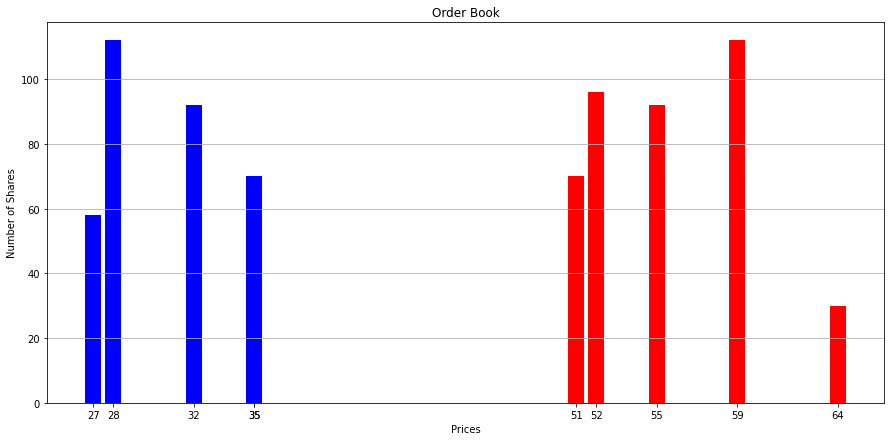

In [5]:
simulator.transition(book).sample().state.display_order_book()

### Create 5 outputs of the `OrderBookSimulator` changes:

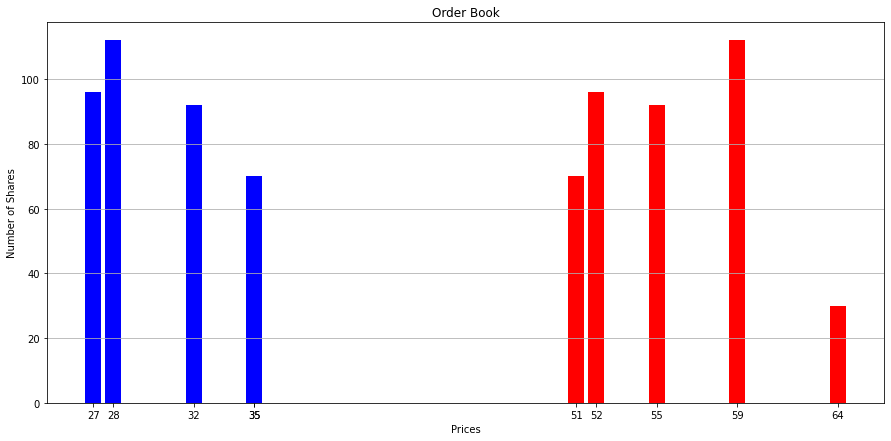

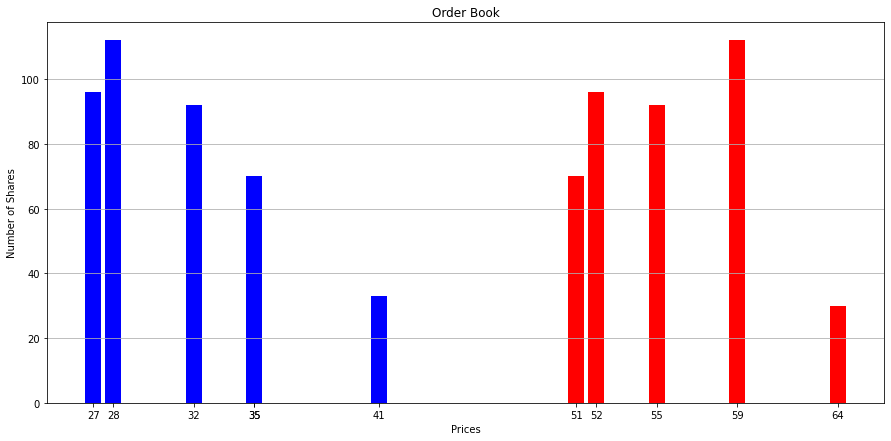

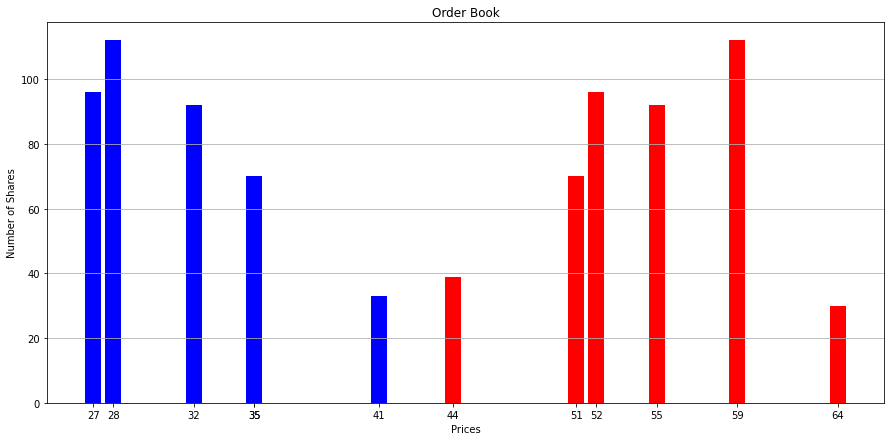

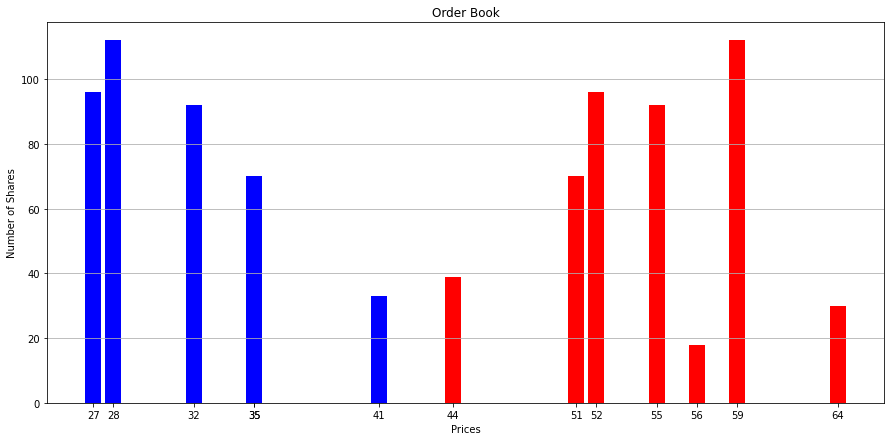

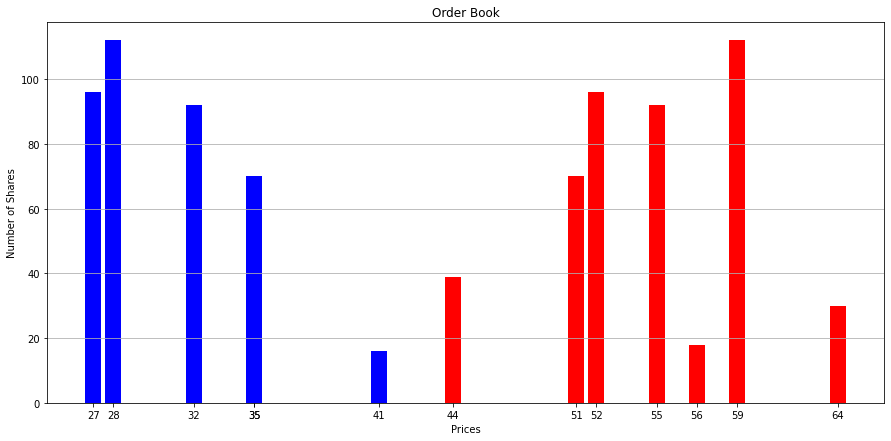

In [6]:
ob_generator = simulator.simulate(Choose([book]))

samples = [i for i in itertools.islice(ob_generator, 5)]

for i in samples:
    i.state.display_order_book()